In [1]:
%pip install nibabel


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Files
import json
import nibabel as nib

# ML / AI / Vision
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.ops import masks_to_boxes
from scipy.ndimage import label as scipy_label

# Visual
import matplotlib.pyplot as plt

# General
import os
from typing import List, Dict
import time
import datetime

from utils import * 

torchvision.__version__, torch.__version__

('0.15.2+cu117', '2.0.1+cu117')

In [2]:
torch.cuda.is_available()

True

In [3]:
LIVER_DATA_PATH = "./Task03_Liver"
os.listdir(LIVER_DATA_PATH)

['._dataset.json',
 'imagesTs',
 '._imagesTr',
 'labelsTr',
 '._labelsTr',
 '._imagesTs',
 'dataset.json',
 'imagesTr']

## Loading, filtering, preparing the data and creating the dataset for the model

In [5]:
DATA_JSON_PATH = "slices_data.json"

with open(DATA_JSON_PATH, "r") as f:
    data = json.load(f)

df_data = pd.DataFrame(data)

In [6]:
print(df_data.dtypes)
df_data

liver_image     object
label_image     object
slice_number     int64
has_liver         bool
has_cancer        bool
cancer_bbox     object
dtype: object


,liver_image,label_image,slice_number,has_liver,has_cancer,cancer_bbox
0,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,0,False,False,[]
1,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,1,False,False,[]
2,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,2,False,False,[]
3,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,3,False,False,[]
4,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,4,False,False,[]
...,...,...,...,...,...,...
58633,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,831,False,False,[]
58634,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,832,False,False,[]
58635,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,833,False,False,[]
58636,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,834,False,False,[]


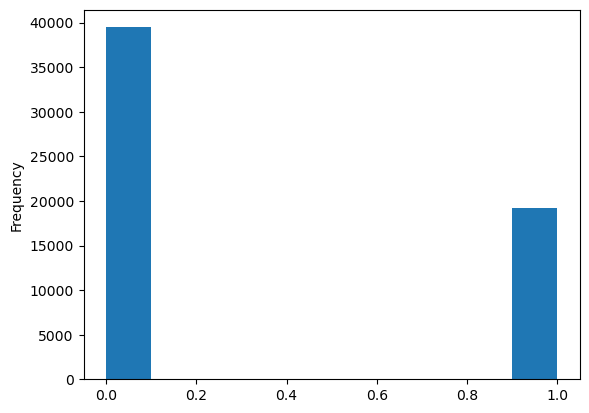

In [7]:
df_data['has_liver'].astype(float).plot.hist()

False    11973
True      7183
Name: has_cancer, dtype: int64


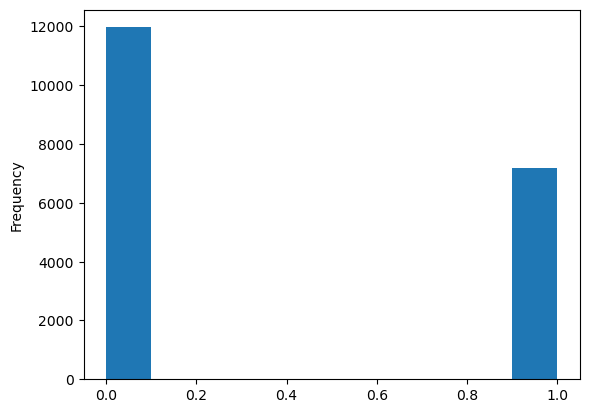

In [8]:
with_liver = df_data[df_data['has_liver'] == True]
print(with_liver['has_cancer'].value_counts())
with_liver['has_cancer'].astype(float).plot.hist()


### Explore invalid Bounding boxes & remove them

In [9]:
df_data[df_data['has_cancer']  == True]

,liver_image,label_image,slice_number,has_liver,has_cancer,cancer_bbox
74,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,74,True,True,"[[320.0, 355.0, 340.0, 376.0]]"
75,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,75,True,True,"[[309.0, 347.0, 336.0, 382.0]]"
76,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,76,True,True,"[[309.0, 345.0, 340.0, 390.0]]"
77,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,77,True,True,"[[308.0, 342.0, 340.0, 390.0]]"
78,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,78,True,True,"[[313.0, 360.0, 333.0, 386.0]]"
...,...,...,...,...,...,...
58365,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,563,True,True,"[[295.0, 391.0, 305.0, 398.0]]"
58366,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,564,True,True,"[[295.0, 390.0, 306.0, 397.0]]"
58367,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,565,True,True,"[[295.0, 390.0, 306.0, 395.0]]"
58368,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,566,True,True,"[[294.0, 390.0, 306.0, 394.0]]"


In [10]:
def is_bbox_valid(bbox):
  """Returns True if the bounding box is valid, False otherwise"""
  if bbox is None:
    return False

  x1, y1, x2, y2 = bbox
  return x1 < x2 and y1 < y2

def remove_invalid_bbox_if_needed(boxes):
    """Returns the list of valid bounding boxes, or None if all bounding boxes are invalid"""
    valid_boxes = [box for box in boxes if is_bbox_valid(box)]
    return valid_boxes if len(valid_boxes) > 0 else None


In [11]:
df_data['valid_cancer_bbox'] = df_data['cancer_bbox'].apply(remove_invalid_bbox_if_needed)

In [12]:
with_cancer = df_data[df_data['has_cancer'] == True]

print("Total invalid slices:", with_cancer['valid_cancer_bbox'].isna().sum())
print("Total valid slices:", with_cancer['valid_cancer_bbox'].notna().sum())

print("Total removed bounding boxes:", with_cancer['cancer_bbox'].apply(lambda x: len(x or [])).sum() - with_cancer['valid_cancer_bbox'].apply(lambda x: len(x or [])).sum())

Total invalid slices: 53
Total valid slices: 7137
Total removed bounding boxes: 1305


Number of cancer pixels: 3
Has cancer: True
[0. 1. 2.]
Number of cancer pixels: 1
Has cancer: True
[0. 1. 2.]


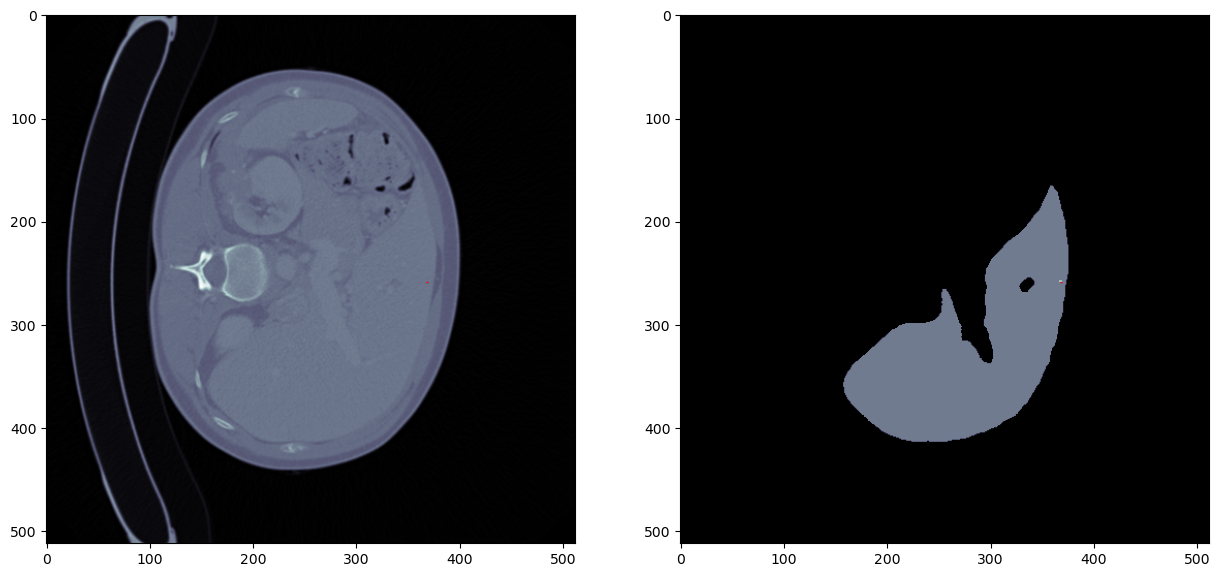

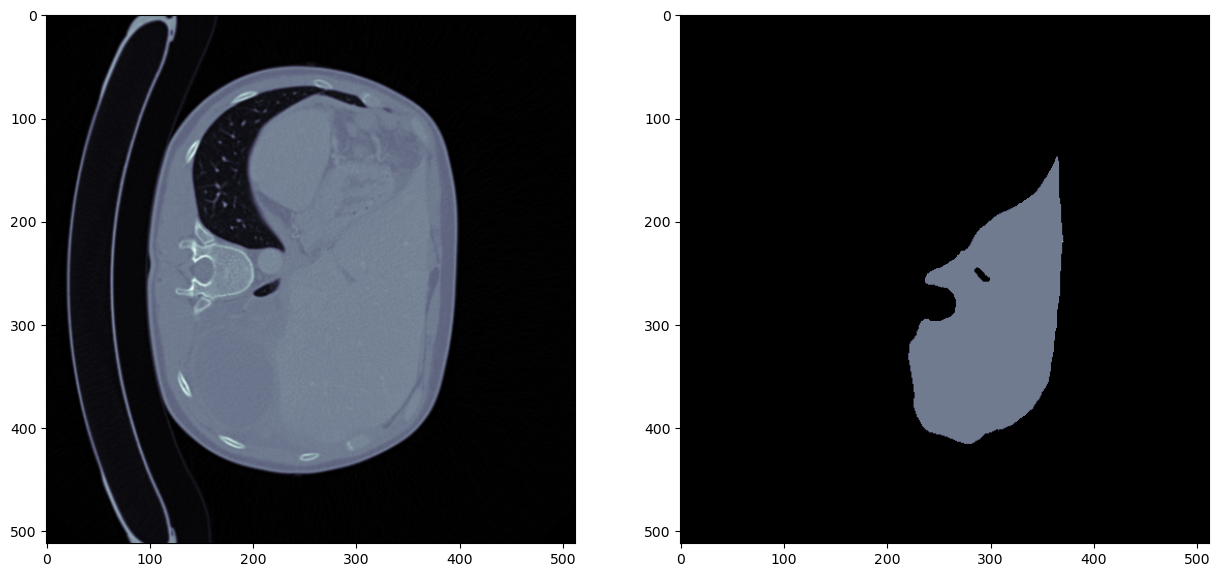

In [13]:
def show_slice(df_row):
    slice_num = df_row.slice_number
    liver_slice = get_image_slice_data(df_row.liver_image, slice_num)
    segmented_slice = get_image_slice_data(df_row.label_image, slice_num)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
    bbs = get_cancer_bounding_boxes(segmented_slice)
    plot_bbs_on_slice(ax1, liver_slice, bbs)
    plot_bbs_on_slice(ax2, segmented_slice, bbs)

    # print the number of cancer pixels
    cancer_pixels = np.sum(segmented_slice == LABEL_CANCER)
    print(f"Number of cancer pixels: {cancer_pixels}")
    print(f"Has cancer: {df_row.has_cancer}")
    print(np.unique(segmented_slice))
    
# Take a look at the slices that have a cancer but the bounding box is invalid
invalid_slices = with_cancer[with_cancer['valid_cancer_bbox'].isna()]
show_slice(invalid_slices.iloc[0])
show_slice(invalid_slices.iloc[1])


Finally, remove all invalid slices & bounding boxes from the dataset

In [17]:
# Drop the invalid slices
df_data_filtered = df_data[df_data['valid_cancer_bbox'].notna()]
# Get only the valid bounding boxes
df_data_filtered = df_data_filtered.drop(columns=['cancer_bbox'])
df_data_filtered.rename(columns={'valid_cancer_bbox': 'cancer_bbox'}, inplace=True)

df_data_filtered

,liver_image,label_image,slice_number,has_liver,has_cancer,cancer_bbox
74,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,74,True,True,"[[320.0, 355.0, 340.0, 376.0]]"
75,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,75,True,True,"[[309.0, 347.0, 336.0, 382.0]]"
76,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,76,True,True,"[[309.0, 345.0, 340.0, 390.0]]"
77,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,77,True,True,"[[308.0, 342.0, 340.0, 390.0]]"
78,./imagesTr/liver_77.nii.gz,./labelsTr/liver_77.nii.gz,78,True,True,"[[313.0, 360.0, 333.0, 386.0]]"
...,...,...,...,...,...,...
58365,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,563,True,True,"[[295.0, 391.0, 305.0, 398.0]]"
58366,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,564,True,True,"[[295.0, 390.0, 306.0, 397.0]]"
58367,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,565,True,True,"[[295.0, 390.0, 306.0, 395.0]]"
58368,./imagesTr/liver_113.nii.gz,./labelsTr/liver_113.nii.gz,566,True,True,"[[294.0, 390.0, 306.0, 394.0]]"


In [18]:
# Sanity check - make sure that all bounding boxes are valid
df_data_filtered['cancer_bbox'].apply(lambda x: len([bbox for bbox in x if is_bbox_valid(bbox)]) > 0).sum() == df_data_filtered.shape[0]

True

#### Dataset Separation - Train / Validation / Test

In [18]:
# Let's split the data into train/val/test
def split_data(df_data, split_ratio=0.8):
  sum = 0
  train_images = []

  total_cancer_slices = df_data.groupby('liver_image').sum("has_cancer")['has_cancer'].sum()
  total_images = len(df_data.groupby('liver_image'))

  for i, row in df_data.groupby('liver_image').sum("has_cancer").iterrows():
    sum += row['has_cancer']
    train_images.append(i)
    if sum/total_cancer_slices >= split_ratio:
      break
  
  print(f"Got total {len(train_images)}/{total_images} images with total {sum}/{total_cancer_slices} slices for training")
  df_train = df_data[df_data['liver_image'].isin(train_images) & df_data['has_cancer'] == True]
  df_test = df_data[~df_data['liver_image'].isin(train_images) & df_data['has_cancer'] == True]
  return df_train, df_test

In [19]:
# Split the data to 80% train and 20% test
df_train, df_test = split_data(df_data_filtered)
df_train.shape, df_test.shape

Got total 105/118 images with total 5718/7137 slices for training


((5718, 6), (1419, 6))

In [20]:
# Split the train samples to 80% train and 20% validation
df_train_train, df_val = split_data(df_train)
df_train_train.shape, df_val.shape

Got total 67/105 images with total 4584/5718 slices for training


((4584, 6), (1134, 6))

# RetinaNet Training

## Dataloader

In [21]:

class LiverDataset(Dataset):
    def __init__(self, df_slices, normalize=True, training=True, random_flip=False):
        self.normalize = normalize
        self.training = training
        self.random_flip = random_flip

        # Filter out only those slices with liver
        self.liver_slices = [LiverSlice(**s) for i, s in df_slices.iterrows() if s['has_cancer'] and i % 2 == 0]
        self.cache: Dict[str, np.ndarray] = {}
        
    def __len__(self):
        return len(self.liver_slices)

    def __getitem__(self, idx: int):
      liver_slice: LiverSlice = self.liver_slices[idx]
      
      liver_image_name = liver_slice.liver_image.split("/")[-1]

      liver_image = self.cache.get(liver_image_name)
      
      if liver_image is None:
        liver_image = get_image_data(liver_slice.liver_image)
        self.cache[liver_image_name] = liver_image
  
      liver_slice_image = liver_image[:, :, liver_slice.slice_number]

      cancer_bbox = torch.as_tensor(liver_slice.cancer_bbox).type(torch.FloatTensor)

      to_tensor = torchvision.transforms.ToTensor()

      liver_slice_image = to_tensor(liver_slice_image).type(torch.FloatTensor)

      if self.normalize:
        mean, std = liver_slice_image.mean(), liver_slice_image.std()
        normalize = transforms.Normalize(mean=[mean], std=[std])
        liver_slice_image = normalize(liver_slice_image)
      
      if self.training and self.random_flip:
        liver_slice_image = transforms.RandomHorizontalFlip(p=0.5)(liver_slice_image)

      target = {
          'boxes': cancer_bbox,
          'labels': torch.tensor([1]*len(liver_slice.cancer_bbox)).type(torch.LongTensor)
      }

      return liver_slice_image, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
# Load all the data
train_dataset = LiverDataset(df_train_train)

print("Train dataset size:", len(train_dataset))

train_dataset[20]

Train dataset size: 2295


(tensor([[[-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433],
          [-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433],
          [-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433],
          ...,
          [-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433],
          [-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433],
          [-0.8433, -0.8433, -0.8433,  ..., -0.8433, -0.8433, -0.8433]]]),
 {'boxes': tensor([[356., 260., 371., 280.]]), 'labels': tensor([1])})

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_retina_model():
    retina = torchvision.models.detection.retinanet_resnet50_fpn_v2(num_classes = 2, pretrained=False, pretrained_backbone = True)
    retina.to(device)
    retina.train()
    params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
    return retina, params

In [27]:
BATCH_SIZE = 4
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
print("Training number of batches:", len(train_data_loader))

Training number of batches: 574


In [36]:
val_dataset = LiverDataset(df_val)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
print("Validation dataset size:", len(val_dataset))
print("Validation number of batches:", len(val_data_loader))

Validation dataset size: 567
Validation number of batches: 284


In [24]:
def format_time(elapsed):
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def train_epoch(model, train_data_batches, optimizer) -> float:
    t0 = time.time()

    epoch_loss = 0

    # Run the training batches.
    for batch_num, (images, targets) in enumerate(train_data_batches):
        if batch_num % 40 == 0 and not batch_num == 0:
            # Calculate elapsed time.
            elapsed = format_time(time.time() - t0)
            print(f"  Batch {batch_num:>5,}  of  {len(train_data_batches):>5,}.    Elapsed: {elapsed}.")

        # Send data to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()

        # Update weights
        optimizer.step()

        epoch_loss += losses.item()

    return epoch_loss / len(train_data_batches)

def evaluate(model, val_data_batches) -> float:
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_data_batches:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()

    return val_loss / len(val_data_loader)

def train_model(model, train_data_batches, val_data_batches, optimizer, n_epochs=10):
    model.train()

    train_losses = []
    val_losses = []

    # We add a learning rate scheduler which decreases the learning rate by 10x every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(n_epochs):
        print(f"======== Epoch {epoch} / {n_epochs} ========")
        t0 = time.time()

        # Train the model on the training data
        print(f"Training on training dataset...")
        epoch_loss = train_epoch(model, train_data_batches, optimizer)

        # Update the learning rate.
        lr_scheduler.step()
        
        # Evaluate on validation dataset
        print(f"Evaluate on validation dataset...")
        val_loss = evaluate(model, val_data_batches)

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        print("\nTrain loss", epoch_loss)
        print("\nValidation loss", val_loss)

        print(f"Training epoch took: {format_time(time.time() - t0)}")

    return train_losses, val_losses

### Start training the model

In [38]:
retina, params = get_retina_model()

LR = 0.0001
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=0.0001)

train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=20)

/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may 

======== Epoch 0 / 20 ========
Training on training dataset...
  Batch    40  of    574.    Elapsed: 0:00:11.
  Batch    80  of    574.    Elapsed: 0:00:22.
  Batch   120  of    574.    Elapsed: 0:00:33.
  Batch   160  of    574.    Elapsed: 0:00:44.
  Batch   200  of    574.    Elapsed: 0:00:54.
  Batch   240  of    574.    Elapsed: 0:01:05.
  Batch   280  of    574.    Elapsed: 0:01:16.
  Batch   320  of    574.    Elapsed: 0:01:27.
  Batch   360  of    574.    Elapsed: 0:01:38.
  Batch   400  of    574.    Elapsed: 0:01:49.
  Batch   440  of    574.    Elapsed: 0:02:00.
  Batch   480  of    574.    Elapsed: 0:02:11.
  Batch   520  of    574.    Elapsed: 0:02:22.
  Batch   560  of    574.    Elapsed: 0:02:32.
Evaluate on validation dataset...

Train loss 1.3343175074364666

Validation loss 1.2456718809168104
Training epoch took: 0:02:53
======== Epoch 1 / 20 ========
Training on training dataset...
  Batch    40  of    574.    Elapsed: 0:00:11.
  Batch    80  of    574.    Elapsed: 0

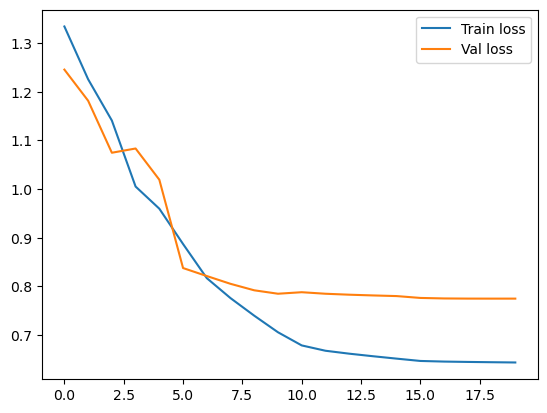

In [39]:
pd.DataFrame({
    'Train loss': train_losses,
    'Val loss': val_losses,
}).plot()

## Hyperparameter Tuning

In [40]:
learning_rates = [0.01, 0.001, 0.0001]
optimizers = {
    'adam': torch.optim.AdamW,
    'sgd': torch.optim.SGD,
}


results = []

for lr in learning_rates:
    for optimizer_name, optimizer_class in optimizers.items():
        print(f"Learning rate: {lr}, optimizer: {optimizer_name}")
        retina, params = get_retina_model()
        
        optimizer = optimizer_class(params, lr=lr, weight_decay=0.0001)
        
        train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=20)
        
        results.append({
            'lr': lr,
            'optimizer': optimizer_name,
            'train_losses': train_losses,
            'val_losses': val_losses,
        })


# Write to json
with open('results-lr.json', 'w') as f:
    json.dump(results, f)

Learning rate: 0.01, optimizer: adam


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may 

======== Epoch 0 / 20 ========
Training on training dataset...
  Batch    40  of    574.    Elapsed: 0:00:11.
  Batch    80  of    574.    Elapsed: 0:00:22.
  Batch   120  of    574.    Elapsed: 0:00:33.
  Batch   160  of    574.    Elapsed: 0:00:44.
  Batch   200  of    574.    Elapsed: 0:00:54.
  Batch   240  of    574.    Elapsed: 0:01:05.
  Batch   280  of    574.    Elapsed: 0:01:16.
  Batch   320  of    574.    Elapsed: 0:01:27.
  Batch   360  of    574.    Elapsed: 0:01:37.
  Batch   400  of    574.    Elapsed: 0:01:49.
  Batch   440  of    574.    Elapsed: 0:02:00.
  Batch   480  of    574.    Elapsed: 0:02:10.
  Batch   520  of    574.    Elapsed: 0:02:21.
  Batch   560  of    574.    Elapsed: 0:02:32.
Evaluate on validation dataset...

Train loss 4.608597497076108

Validation loss 1.3700124612996276
Training epoch took: 0:02:52
======== Epoch 1 / 20 ========
Training on training dataset...
  Batch    40  of    574.    Elapsed: 0:00:11.
  Batch    80  of    574.    Elapsed: 0:

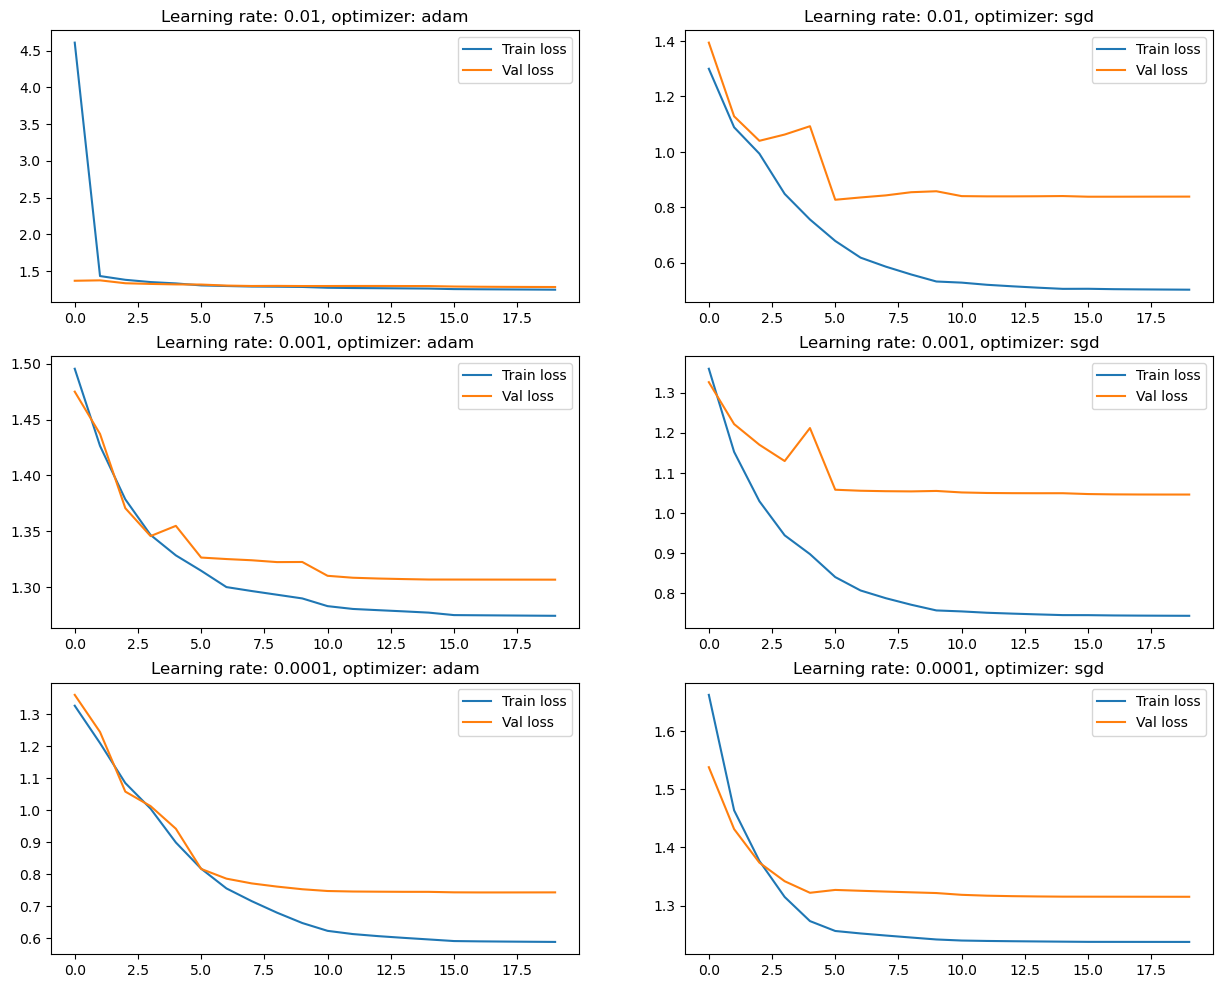

In [41]:
results

# Plot results
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
for result in results:

    row = learning_rates.index(result['lr'])
    col = 0 if result['optimizer'] == 'adam' else 1

    pd.DataFrame({
        'Train loss': result['train_losses'],
        'Val loss': result['val_losses'],
    }).plot(title=f"Learning rate: {result['lr']}, optimizer: {result['optimizer']}", ax=ax[row][col])
    ax[row][col].set_title(f"Learning rate: {result['lr']}, optimizer: {result['optimizer']}")    

In [42]:
# Check where the validation loss is lowest
for result in results:
    print(f"Learning rate: {result['lr']}, optimizer: {result['optimizer']}")
    print(f"Min val loss: {min(result['val_losses'])}")
    print(f"Min val loss epoch: {np.argmin(result['val_losses'])}")
    print()
    
min_val_losses = [(min(result['val_losses']), min(result['train_losses'])) for result in results]
print(f"Min val loss: {min(min_val_losses)}")

Learning rate: 0.01, optimizer: adam
Min val loss: 1.284872162509972
Min val loss epoch: 19

Learning rate: 0.01, optimizer: sgd
Min val loss: 0.8276653377942635
Min val loss epoch: 5

Learning rate: 0.001, optimizer: adam
Min val loss: 1.3068104478674876
Min val loss epoch: 19

Learning rate: 0.001, optimizer: sgd
Min val loss: 1.0464459479274884
Min val loss epoch: 19

Learning rate: 0.0001, optimizer: adam
Min val loss: 0.743122575253668
Min val loss epoch: 16

Learning rate: 0.0001, optimizer: sgd
Min val loss: 1.315112699505309
Min val loss epoch: 19

Min val loss: (0.743122575253668, 0.5884732930346649)


## Test different batch sizes

In [29]:
BATCH_SIZES = [2,4,8,16]
results = []

for batch_size in BATCH_SIZES:
    train_dataset = LiverDataset(df_train_train, normalize=False)
    val_dataset = LiverDataset(df_val, normalize=False)
    print(f"Batch size: {batch_size}")

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    retina, params = get_retina_model()
    
    optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0001)
    
    train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=20)
    
    results.append({
        'batch_size': batch_size,
        'train_losses': train_losses,
        'val_losses': val_losses,
    })

# Write to json
with open('results_bs_no_norm.json', 'w') as f:
    json.dump(results, f)
    


Batch size: 2
======== Epoch 0 / 20 ========
Training on training dataset...
  Batch    40  of  1,148.    Elapsed: 0:02:30.
  Batch    80  of  1,148.    Elapsed: 0:03:08.
  Batch   120  of  1,148.    Elapsed: 0:03:31.
  Batch   160  of  1,148.    Elapsed: 0:03:47.
  Batch   200  of  1,148.    Elapsed: 0:03:58.
  Batch   240  of  1,148.    Elapsed: 0:04:05.
  Batch   280  of  1,148.    Elapsed: 0:04:11.
  Batch   320  of  1,148.    Elapsed: 0:04:18.
  Batch   360  of  1,148.    Elapsed: 0:04:27.
  Batch   400  of  1,148.    Elapsed: 0:04:33.
  Batch   440  of  1,148.    Elapsed: 0:04:38.
  Batch   480  of  1,148.    Elapsed: 0:04:44.
  Batch   520  of  1,148.    Elapsed: 0:04:57.
  Batch   560  of  1,148.    Elapsed: 0:05:03.
  Batch   600  of  1,148.    Elapsed: 0:05:09.
  Batch   640  of  1,148.    Elapsed: 0:05:19.
  Batch   680  of  1,148.    Elapsed: 0:05:24.
  Batch   720  of  1,148.    Elapsed: 0:05:30.
  Batch   760  of  1,148.    Elapsed: 0:05:36.
  Batch   800  of  1,148.    E

KeyboardInterrupt: 

In [35]:
results

[{'batch_size': 2,
  'train_losses': [1.2088633509878497,
   0.8920061151117398,
   0.7430165575667956,
   0.6271319279142166,
   0.5702856502103058,
   0.4473605327152417,
   0.3975443896944618,
   0.3617587936912316,
   0.3320303556447661,
   0.30846452792840345,
   0.2834493504635964,
   0.27542867519947917,
   0.27086103970399095,
   0.26680253570711154,
   0.2625934717242155,
   0.2586266298385707,
   0.2579529394723397,
   0.2576269937731092,
   0.25700623530388295,
   0.2567233536716953],
  'val_losses': [0.9593750374837661,
   0.8067130554519909,
   0.7233611352112091,
   0.751628262161369,
   0.6992989890277386,
   0.7019004453183479,
   0.7268547249931685,
   0.7368714514280289,
   0.8154855500119673,
   0.8015961598762325,
   0.8263528385580006,
   0.8384377142335747,
   0.8525255585850124,
   0.8553041301825097,
   0.8669899900404501,
   0.8676512621500543,
   0.86936531877014,
   0.8699568461259486,
   0.8706862272458596,
   0.871344209845427]},
 {'batch_size': 4,
  'train

Batch size: 2
Min val loss: 0.6992989890277386
Min val loss epoch: 4

Batch size: 4
Min val loss: 0.7629067014220735
Min val loss epoch: 3

Batch size: 8
Min val loss: 0.7132058930648885
Min val loss epoch: 5

Batch size: 16
Min val loss: 0.7329471790128284
Min val loss epoch: 2

Min val loss: (0.6992989890277386, 0.2567233536716953)


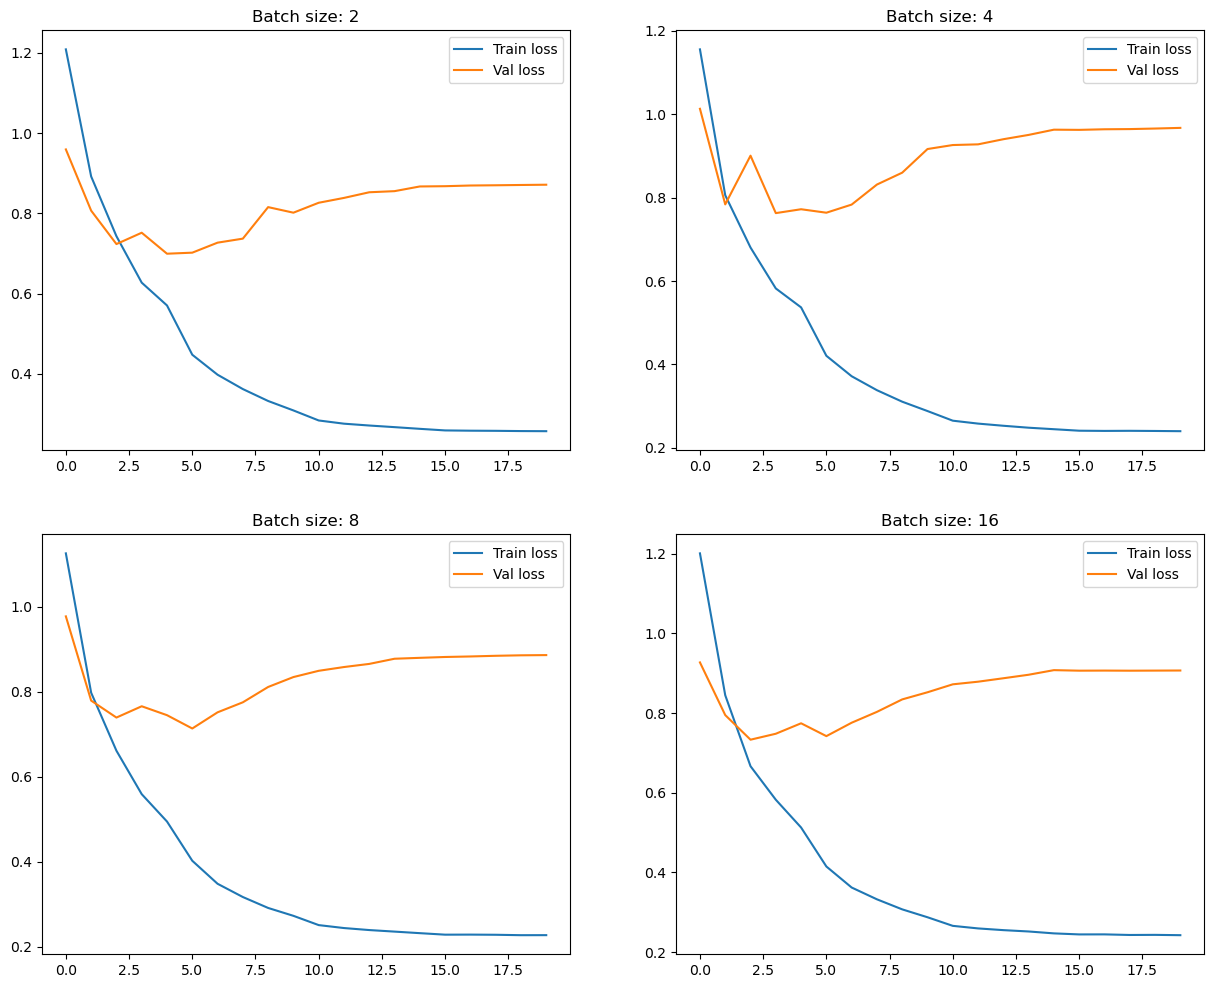

In [36]:
# plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
for result in results:
    row = BATCH_SIZES.index(result['batch_size']) // 2
    col = BATCH_SIZES.index(result['batch_size']) % 2

    pd.DataFrame({
        'Train loss': result['train_losses'],
        'Val loss': result['val_losses'],
    }).plot(title=f"Batch size: {result['batch_size']}", ax=ax[row][col])
    ax[row][col].set_title(f"Batch size: {result['batch_size']}")

# Check where the validation loss is lowest
for result in results:
    print(f"Batch size: {result['batch_size']}")
    print(f"Min val loss: {min(result['val_losses'])}")
    print(f"Min val loss epoch: {np.argmin(result['val_losses'])}")
    print()

min_val_losses = [(min(result['val_losses']), min(result['train_losses'])) for result in results]
print(f"Min val loss: {min(min_val_losses)}")


### Test random flipping during training

with normalize, with random flipping, batch size 8, 10 epochs, Adam, lr 0.0001

In [27]:
BATCH_SIZE = 2

flip_results = []

for flip in [True, False]:
    print(f"Flip: {flip}")
    train_dataset = LiverDataset(df_train_train, random_flip=flip)
    val_dataset = LiverDataset(df_val, random_flip=flip)
    train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    retina, params = get_retina_model()
    
    optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0001)
    
    train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=10)
    
    flip_results.append({
        'flip': flip,
        'train_losses': train_losses,
        'val_losses': val_losses,
    })

# Write to json
with open('results_flip.json', 'w') as f:
    json.dump(flip_results, f)

flip_results

Flip: True


/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may 

======== Epoch 0 / 10 ========
Training on training dataset...
  Batch    40  of  1,148.    Elapsed: 0:02:37.
  Batch    80  of  1,148.    Elapsed: 0:03:20.
  Batch   120  of  1,148.    Elapsed: 0:03:37.
  Batch   160  of  1,148.    Elapsed: 0:03:50.
  Batch   200  of  1,148.    Elapsed: 0:03:56.
  Batch   240  of  1,148.    Elapsed: 0:04:02.
  Batch   280  of  1,148.    Elapsed: 0:04:12.
  Batch   320  of  1,148.    Elapsed: 0:04:23.
  Batch   360  of  1,148.    Elapsed: 0:04:29.
  Batch   400  of  1,148.    Elapsed: 0:04:46.
  Batch   440  of  1,148.    Elapsed: 0:04:52.
  Batch   480  of  1,148.    Elapsed: 0:04:58.
  Batch   520  of  1,148.    Elapsed: 0:05:04.
  Batch   560  of  1,148.    Elapsed: 0:05:10.
  Batch   600  of  1,148.    Elapsed: 0:05:23.
  Batch   640  of  1,148.    Elapsed: 0:05:29.
  Batch   680  of  1,148.    Elapsed: 0:05:35.
  Batch   720  of  1,148.    Elapsed: 0:05:41.
  Batch   760  of  1,148.    Elapsed: 0:05:47.
  Batch   800  of  1,148.    Elapsed: 0:05:5

[{'flip': True,
  'train_losses': [1.3107135690982334,
   1.1749564364085214,
   1.0569553650162777,
   0.9839613021250802,
   0.8786429230655942,
   0.7282321409611129,
   0.6695738849635738,
   0.6238731799666682,
   0.5907391946022934,
   0.561071819025465],
  'val_losses': [1.3157387438794257,
   1.1954082172941154,
   1.1548698375552473,
   1.1621690324284661,
   1.1975299954204492,
   1.1553533516404495,
   1.1796966098563773,
   1.1956191846287587,
   1.23780812155193,
   1.27573920308914]},
 {'flip': False,
  'train_losses': [1.1506329695937525,
   0.8234117255912841,
   0.6938289850041633,
   0.6481220294893411,
   0.5379922340400127,
   0.42641482702764694,
   0.37615712722341565,
   0.3431415653654507,
   0.3138112068007528,
   0.2915367564439566],
  'val_losses': [0.8676748008165561,
   0.9226972166921051,
   0.7131084681711566,
   0.7113690388349581,
   0.7325240631758327,
   0.7002655038951149,
   0.7287403614535718,
   0.7696839628977256,
   0.837052413328013,
   0.85794

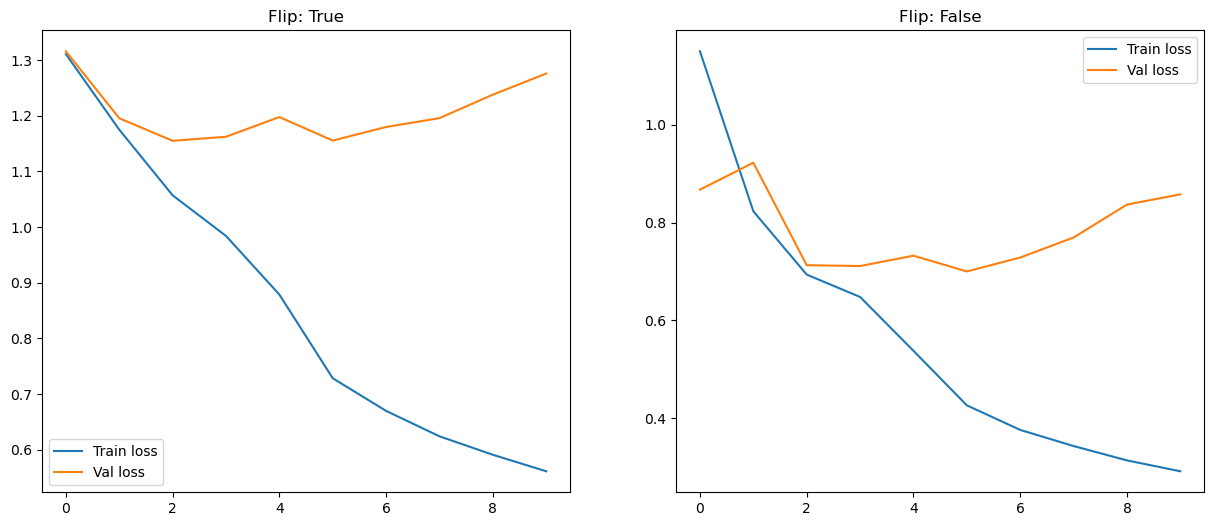

Flip: True
Min val loss: 1.1548698375552473
Min val loss epoch: 2
Flip: False
Min val loss: 0.7002655038951149
Min val loss epoch: 5


In [28]:
# Plot results side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

pd.DataFrame({
    'Train loss': flip_results[0]['train_losses'],
    'Val loss': flip_results[0]['val_losses'],
}).plot(title=f"Flip: {flip_results[0]['flip']}", ax=ax1)

pd.DataFrame({
    'Train loss': flip_results[1]['train_losses'],
    'Val loss': flip_results[1]['val_losses'],
}).plot(title=f"Flip: {flip_results[1]['flip']}", ax=ax2)

plt.show()

# Check where the validation loss is lowest
for result in flip_results:
    print(f"Flip: {result['flip']}")
    print(f"Min val loss: {min(result['val_losses'])}")
    print(f"Min val loss epoch: {np.argmin(result['val_losses'])}")

======== Epoch 0 / 5 ========
Training on training dataset...
  Batch    40  of  1,148.    Elapsed: 0:02:07.
  Batch    80  of  1,148.    Elapsed: 0:02:45.
  Batch   120  of  1,148.    Elapsed: 0:03:07.
  Batch   160  of  1,148.    Elapsed: 0:03:20.
  Batch   200  of  1,148.    Elapsed: 0:03:28.
  Batch   240  of  1,148.    Elapsed: 0:03:39.
  Batch   280  of  1,148.    Elapsed: 0:03:49.
  Batch   320  of  1,148.    Elapsed: 0:03:58.
  Batch   360  of  1,148.    Elapsed: 0:04:04.
  Batch   400  of  1,148.    Elapsed: 0:04:10.
  Batch   440  of  1,148.    Elapsed: 0:04:16.
  Batch   480  of  1,148.    Elapsed: 0:04:25.
  Batch   520  of  1,148.    Elapsed: 0:04:35.
  Batch   560  of  1,148.    Elapsed: 0:04:41.
  Batch   600  of  1,148.    Elapsed: 0:04:47.
  Batch   640  of  1,148.    Elapsed: 0:04:53.
  Batch   680  of  1,148.    Elapsed: 0:04:59.
  Batch   720  of  1,148.    Elapsed: 0:05:05.
  Batch   760  of  1,148.    Elapsed: 0:05:18.
  Batch   800  of  1,148.    Elapsed: 0:05:24

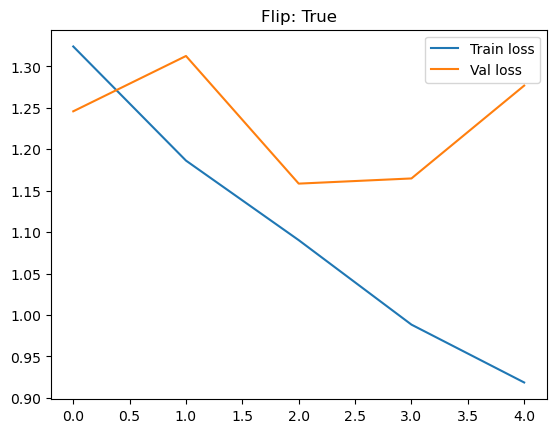

In [33]:
# Train the model with Flip=True
train_dataset = LiverDataset(df_train_train, random_flip=True)
val_dataset = LiverDataset(df_val, random_flip=True)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

retina, params = get_retina_model()

optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0001)

train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=5)

# Write model to file
torch.save(retina.state_dict(), 'retina_flip_bs2.pt')

# plot results
pd.DataFrame({
    'Train loss': train_losses,
    'Val loss': val_losses,
}).plot(title=f"Flip: {True}")



## Train the best model

In [25]:
BATCH_SIZE = 2
LR = 0.0001
EPOCHS = 5

train_dataset = LiverDataset(df_train_train)
val_dataset = LiverDataset(df_val)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

retina, params = get_retina_model()

optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=0.0001)

train_losses, val_losses = train_model(retina, train_data_loader, val_data_loader, optimizer, n_epochs=EPOCHS)

/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may 

======== Epoch 0 / 5 ========
Training on training dataset...
  Batch    40  of  1,148.    Elapsed: 0:02:36.
  Batch    80  of  1,148.    Elapsed: 0:03:11.
  Batch   120  of  1,148.    Elapsed: 0:03:30.
  Batch   160  of  1,148.    Elapsed: 0:03:37.
  Batch   200  of  1,148.    Elapsed: 0:03:50.
  Batch   240  of  1,148.    Elapsed: 0:03:58.
  Batch   280  of  1,148.    Elapsed: 0:04:10.
  Batch   320  of  1,148.    Elapsed: 0:04:16.
  Batch   360  of  1,148.    Elapsed: 0:04:26.
  Batch   400  of  1,148.    Elapsed: 0:04:32.
  Batch   440  of  1,148.    Elapsed: 0:04:38.
  Batch   480  of  1,148.    Elapsed: 0:04:44.
  Batch   520  of  1,148.    Elapsed: 0:04:51.
  Batch   560  of  1,148.    Elapsed: 0:04:57.
  Batch   600  of  1,148.    Elapsed: 0:05:03.
  Batch   640  of  1,148.    Elapsed: 0:05:09.
  Batch   680  of  1,148.    Elapsed: 0:05:15.
  Batch   720  of  1,148.    Elapsed: 0:05:21.
  Batch   760  of  1,148.    Elapsed: 0:05:29.
  Batch   800  of  1,148.    Elapsed: 0:05:43

In [26]:
# Save the model
torch.save(retina.state_dict(), 'retina_bs2_e5.pt')

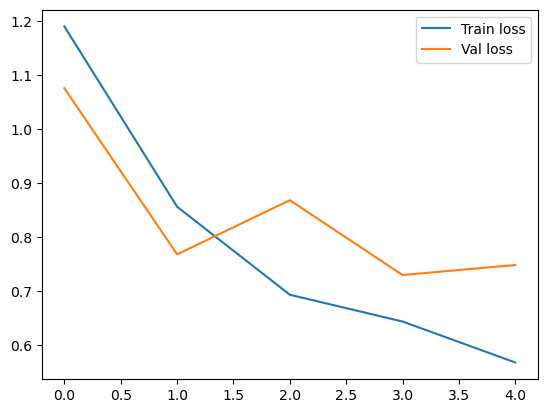

In [27]:
pd.DataFrame({
    'Train loss': train_losses,
    'Val loss': val_losses,
}).plot()